run this

In [226]:
%load_ext autoreload
%autoreload 2
# Enable imports form top-level of project (edit top_level_path accordingly)
import os
import sys
import inspect

top_level_path = os.path.abspath(os.path.join('..'))
if top_level_path not in sys.path:
	sys.path.append(top_level_path)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from longestpath.gen import gen_num_edges, gen_num_edges_undirected, gen_planted_hamiltonian_undirected_fixed_degree
from benchmarking import RandomParams, Benchmark, new_random_benchmark, Solver, new_graph_file_benchmark, new_benchmark
import matplotlib.colors as mcolors
import re

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [297]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
all_methods = ["brute('BRANCH_N_BOUND')",
 "brute('BRUTE_FORCE')",
 "brute('BRUTE_FORCE_COMPLETE')",
 "brute('FAST_BOUND')",
 'ilp()',
 'kalp()',
 'kalp(threads=4)']

color_assignment = {method : col for method, col in zip(all_methods, colors)}
color_assignment

{"brute('BRANCH_N_BOUND')": '#1f77b4',
 "brute('BRUTE_FORCE')": '#ff7f0e',
 "brute('BRUTE_FORCE_COMPLETE')": '#2ca02c',
 "brute('FAST_BOUND')": '#d62728',
 'ilp()': '#9467bd',
 'kalp()': '#8c564b',
 'kalp(threads=4)': '#e377c2'}

In [3]:
def generate():
  return [
    gen_planted_hamiltonian_undirected_fixed_degree(30, round(30 * deg / 2))
    for deg in np.linspace(1.0, 10.0, 10) for _ in range(50)
  ]

params_code = inspect.getsource(generate)
graphs = generate()

benchmark = new_benchmark(graphs, solvers=[
	Solver("brute", "FAST_BOUND"),
	Solver("brute", "BRUTE_FORCE"),
	Solver("brute", "BRANCH_N_BOUND"),
	# Solver("brute", "BRUTE_FORCE_COMPLETE"),
	Solver("ilp"),
	Solver("kalp", threads=4),
	# Solver("kalp"),
], params_code = params_code, override_benchmark_path="../final_benchmarks/only_ham_3brute_ilp_kalp_deg1-10_50runs")

benchmark.benchmark_path


'../final_benchmarks/only_ham_3brute_ilp_kalp_deg1-10_50runs'

In [158]:
np.linspace(10, 30, 10)

array([10.        , 12.22222222, 14.44444444, 16.66666667, 18.88888889,
       21.11111111, 23.33333333, 25.55555556, 27.77777778, 30.        ])

run this

In [3]:
benchmark = Benchmark.load("../final_benchmarks/only_ham_3brute_ilp_kalp_deg1-10_50runs/")

In [4]:
benchmark.run(retryFailures=True, timeout=3 * 60)


graph: 0.txt, solver: brute('FAST_BOUND') ... ✅
length: 29, run_time: 1.1e-05
graph: 1.txt, solver: brute('FAST_BOUND') ... ✅
length: 29, run_time: 2e-05
graph: 2.txt, solver: brute('FAST_BOUND') ... ✅
length: 29, run_time: 1.3e-05
graph: 3.txt, solver: brute('FAST_BOUND') ... 

✅
length: 29, run_time: 1.2e-05
graph: 4.txt, solver: brute('FAST_BOUND') ... ✅
length: 29, run_time: 1.2e-05
graph: 5.txt, solver: brute('FAST_BOUND') ... ✅
length: 29, run_time: 1.2e-05
graph: 6.txt, solver: brute('FAST_BOUND') ... ✅
length: 29, run_time: 1.2e-05
graph: 7.txt, solver: brute('FAST_BOUND') ... ✅
length: 29, run_time: 1.3e-05
graph: 8.txt, solver: brute('FAST_BOUND') ... ✅
length: 29, run_time: 1.1e-05
graph: 9.txt, solver: brute('FAST_BOUND') ... ✅
length: 29, run_time: 1.2e-05
graph: 10.txt, solver: brute('FAST_BOUND') ... ✅
length: 29, run_time: 1.1e-05
graph: 11.txt, solver: brute('FAST_BOUND') ... ✅
length: 29, run_time: 2.8e-05
graph: 12.txt, solver: brute('FAST_BOUND') ... ✅
length: 29, run_time: 1.3e-05
graph: 13.txt, solver: brute('FAST_BOUND') ... ✅
length: 29, run_time: 1.2e-05
graph: 14.txt, solver: brute('FAST_BOUND') ... ✅
length: 29, run_time: 1.2e-05
graph: 15.txt, solver: brute('FAST_BOUND') ... ✅
length: 29, run_time: 1.2e-05
graph: 16.txt, solver: bru

run everything after this

In [4]:
df_ = benchmark.get_dataframe()
if not "failure" in df_:
    df_["failure"] = None
df = df_
df.head()

,path,run_time,length,solver,graph_id,status,objective_value,failure,solver_name,vertices,edges,average_out_degree
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.000011,29.0,0,0,NaN,NaN,NaN,brute('FAST_BOUND'),30,58,1.933333
1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.000020,29.0,0,1,NaN,NaN,NaN,brute('FAST_BOUND'),30,58,1.933333
2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.000013,29.0,0,2,NaN,NaN,NaN,brute('FAST_BOUND'),30,58,1.933333
3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.000012,29.0,0,3,NaN,NaN,NaN,brute('FAST_BOUND'),30,58,1.933333
4,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.000012,29.0,0,4,NaN,NaN,NaN,brute('FAST_BOUND'),30,58,1.933333


In [5]:
df[(df["solver_name"] == "ilp()") & (df["length"] != 29)]

,path,run_time,length,solver,graph_id,status,objective_value,failure,solver_name,vertices,edges,average_out_degree


run_time    Axes(0.125,0.11;0.775x0.77)
dtype: object

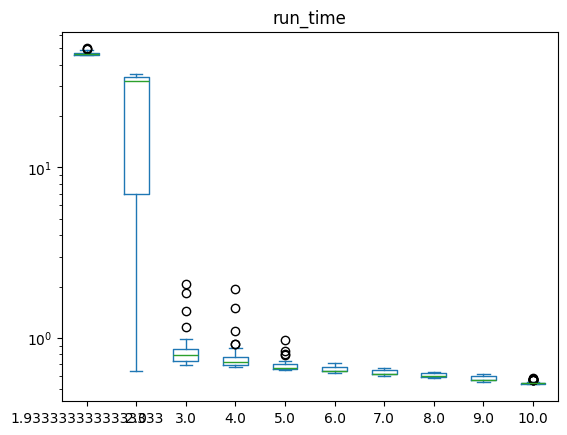

In [6]:
df[df["solver_name"] == "ilp()"][["run_time", "average_out_degree"]].plot.box(by="average_out_degree", logy=True)


In [299]:
df_grouped = df \
  .groupby(['average_out_degree', 'solver', 'solver_name']) \
  .agg({
    "run_time": ["mean", "median", "std"], 
    "failure": "any"
  }) \
  .reset_index() \
  .rename(columns={"any": ""})

df_grouped.columns = [a + ("_" + b if b != "" else "")  for (a,b) in df_grouped.columns]

df_grouped_failures_removed = df_grouped[df_grouped["failure"] == False]
to_plot = df_grouped_failures_removed.pivot(
  index='average_out_degree', 
  columns='solver_name', 
  values=['run_time_mean', 'run_time_std']
).reset_index()


In [301]:
df_grouped_failures_removed.groupby(["solver_name"]).agg({"failure": "count"}).reset_index().rename(columns={"failure": "count"})

,solver_name,count
0,brute('BRANCH_N_BOUND'),10
1,brute('BRUTE_FORCE'),10
2,brute('FAST_BOUND'),10
3,ilp(),10
4,kalp(threads=4),4


In [302]:
df_grouped_failures_removed.head()

,average_out_degree,solver,solver_name,run_time_mean,run_time_median,run_time_std,failure
0,1.933333,0,brute('FAST_BOUND'),0.000013,0.000013,3.077834e-06,False
1,1.933333,1,brute('BRUTE_FORCE'),0.000002,0.000002,3.958973e-07,False
2,1.933333,2,brute('BRANCH_N_BOUND'),0.000004,0.000004,1.397374e-06,False
3,1.933333,3,ilp(),46.831174,46.170734,1.126196e+00,False
4,1.933333,4,kalp(threads=4),1.925778,1.925459,6.215199e-02,False


In [303]:
to_plot


average_out_degree           run_time_mean                       \
solver_name                    brute('BRANCH_N_BOUND') brute('BRUTE_FORCE')   
0                     1.933333                0.000004             0.000002   
1                     2.000000                0.000007             0.000003   
2                     3.000000                0.000838             0.000547   
3                     4.000000                0.011184             0.034607   
4                     5.000000                0.010062             0.083281   
5                     6.000000                0.040832             0.166812   
6                     7.000000                0.007485             0.035776   
7                     8.000000                0.000115             0.490761   
8                     9.000000                0.000087             0.000141   
9                    10.000000                0.000022             0.000048   

                                                            \
solver_name brute('FAST_BOUND')      ilp() kalp(threads=4)   
0                      0.000013  46.831174        1.925778   
1                      0.000015  22.522745        1.984495   
2                      0.005441   0.853429        0.457396   
3                      0.589332   0.783782        4.969584   
4                      1.728413   0.687463             NaN   
5                      0.025436   0.653658             NaN   
6                      0.084233   0.625508             NaN   
7                      0.000492   0.604577             NaN   
8                      0.000066   0.575070             NaN   
9                      0.000031   0.545543             NaN   

                       run_time_std                                           \
solver_name brute('BRANCH_N_BOUND') brute('BRUTE_FORCE') brute('FAST_BOUND')   
0                          0.000001         3.958973e-07            0.000003   
1                          0.000002         2.618693e-06            0.000005   
2                          0.000747         5.053869e-04            0.014219   
3                          0.033826         1.011500e-01            3.861899   
4                          0.033551         3.554332e-01           11.961825   
5                          0.284593         1.164126e+00            0.101154   
6                          0.037204         1.483425e-01            0.361547   
7                          0.000174         3.466863e+00            0.002075   
8                          0.000291         5.154782e-04            0.000254   
9                          0.000045         2.257190e-04            0.000123   

                                        
solver_name      ilp() kalp(threads=4)  
0             1.126196        0.062152  
1            14.043347        0.475445  
2             0.261148        0.992908  
3             0.211930       14.008459  
4             0.056014             NaN  
5             0.021568             NaN  
6             0.017987             NaN  
7             0.017656             NaN  
8             0.016829             NaN  
9             0.013173             NaN

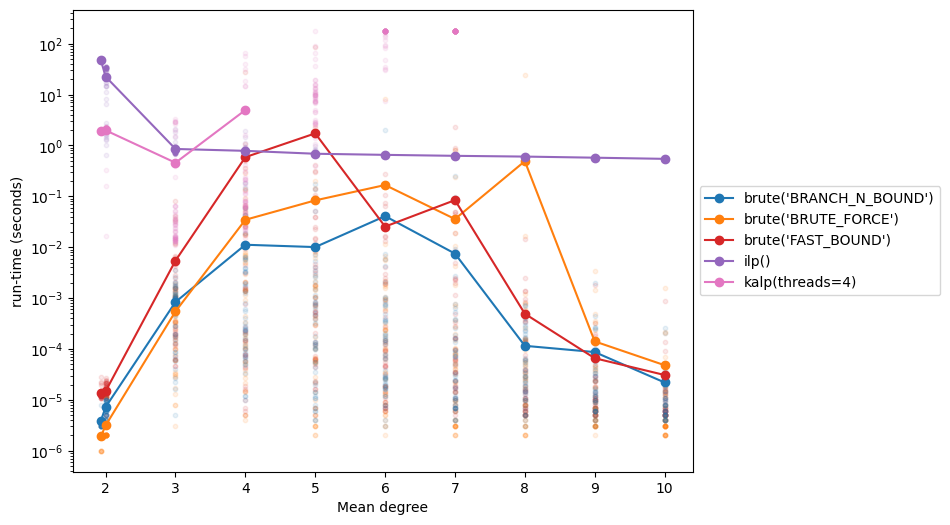

In [323]:
view = df[['average_out_degree', 'solver_name','length', 'run_time']]

# to_plot = df.groupby(['average_out_degree', 'solver', 'solver_name']).agg({'run_time': 'mean'}).reset_index() \
#     .pivot(index='average_out_degree', columns='solver_name', values='run_time') \
#     .rename(columns=lambda x: x + " (average)");

to_plot.plot(style="o-", x="average_out_degree", y="run_time_mean", color=color_assignment)

for solver_name in benchmark.solver_names():
    solver_df = df[df["solver_name"] == solver_name]  # Select rows where run-time is not null
    plt.scatter(
        solver_df['average_out_degree'], 
        solver_df['run_time'], 
        label=solver_name, 
        alpha=0.1, 
        s=10,
        color=color_assignment[solver_name]
    )

plt.yscale('log')

plt.ylabel("run-time (seconds)")
plt.xlabel("Mean degree")
methods = list(to_plot.columns.droplevel())
plt.legend(methods[1:len(methods)//2+1], loc='center left', bbox_to_anchor=(1, 0.5))



plt.gcf().set_size_inches(8, 6)
plt.savefig(os.path.join(benchmark.benchmark_path, "plot.png"), dpi=400, bbox_inches='tight')

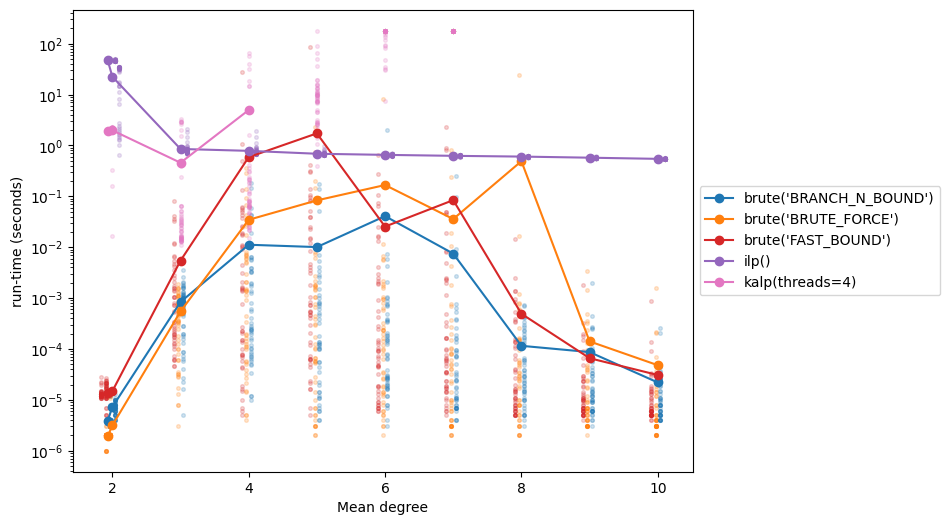

In [326]:
view = df[['average_out_degree', 'solver_name','length', 'run_time']]

fig, ax = plt.subplots()

to_plot.plot(
    style="o-", 
    x="average_out_degree", 
    y="run_time_mean", 
    color=color_assignment, 
    ax=ax
)

offsets = list(np.linspace(-0.1,0.1,4)) + [0]

for offset, solver_name in zip(offsets, benchmark.solver_names()):
    solver_df = df[df["solver_name"] == solver_name]  # Select rows where run-time is not null
    plt.scatter(
        solver_df['average_out_degree'] + offset,  
        solver_df['run_time'], 
        label=solver_name, 
        alpha=0.2, 
        s=7,
        color=color_assignment[solver_name]
    )
plt.yscale('log')

plt.ylabel("run-time (seconds)")
plt.xlabel("Mean degree")
methods = list(to_plot.columns.droplevel())
plt.legend(methods[1:len(methods)//2+1], loc='center left', bbox_to_anchor=(1, 0.5))

plt.gcf().set_size_inches(8, 6)
plt.savefig(os.path.join(benchmark.benchmark_path, "plot.png"), dpi=400, bbox_inches='tight')

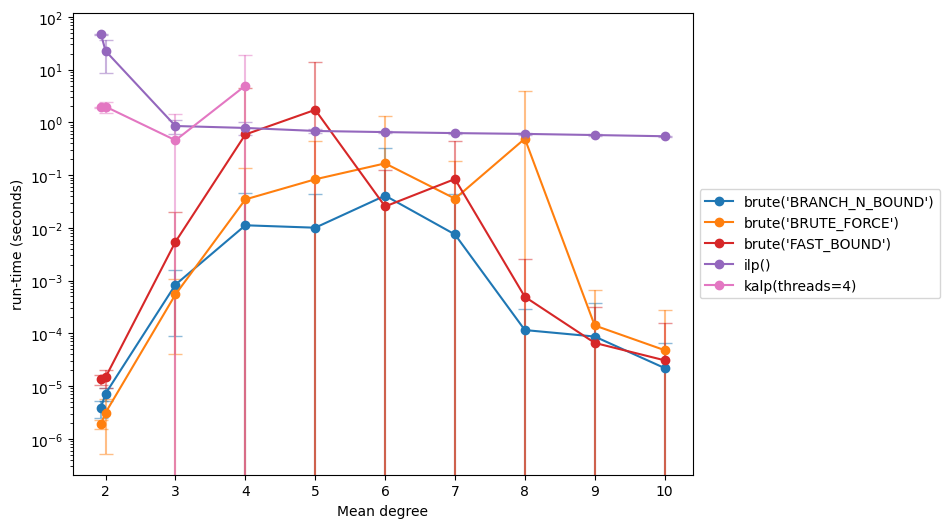

In [321]:
fig, ax = plt.subplots()

to_plot.plot(
  fmt=".", 
  x="average_out_degree",
  y="run_time_mean", 
  yerr="run_time_std", 
  capsize=5,
  ax=ax,
  alpha=0.5,
  color=color_assignment,
  legend=False,
  # linewidth=3
)
to_plot.plot(
  style="o-", 
  x="average_out_degree",
  y="run_time_mean", 
  color=color_assignment,
  ax=ax,
)
plt.yscale('log')

plt.ylabel("run-time (seconds)")
plt.xlabel("Mean degree")
methods = list(to_plot.columns.droplevel())
plt.legend(methods[1:len(methods)//2+1], loc='center left', bbox_to_anchor=(1, 0.5))

plt.gcf().set_size_inches(8, 6)

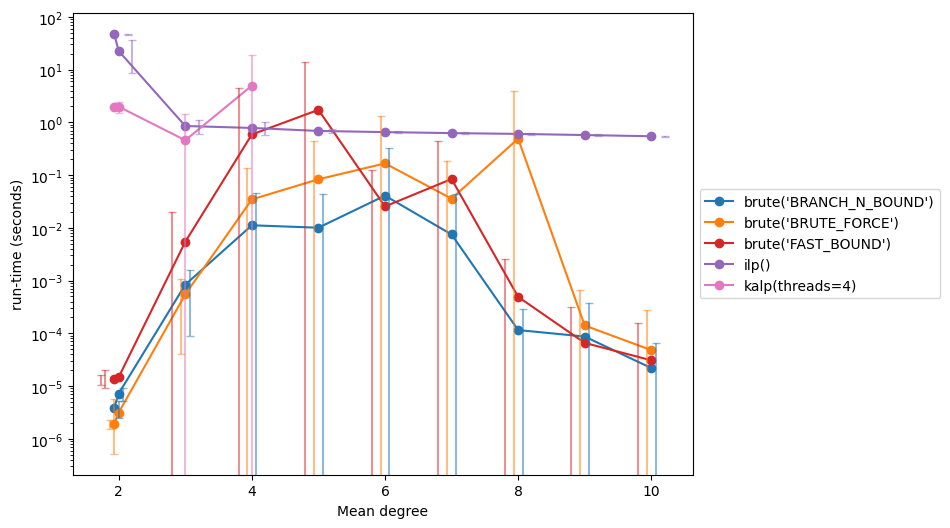

In [320]:
fig, ax = plt.subplots()


to_plot.plot(
  style="o-",
  x="average_out_degree",
  y="run_time_mean", 
  color=color_assignment,
  ax=ax,
)

offsets = list(np.linspace(-0.2,0.2,4)) + [0]

for offset, solver_name in zip(offsets, benchmark.solver_names()):
  plt.errorbar(
    to_plot['average_out_degree'] + offset,
    to_plot['run_time_mean'][solver_name],
    yerr = to_plot['run_time_std'][solver_name],
    fmt='none',
    capsize=3,
    alpha=0.5,
    color=color_assignment[solver_name],
  )
plt.yscale('log')

plt.ylabel("run-time (seconds)")
plt.xlabel("Mean degree")
methods = list(to_plot.columns.droplevel())
plt.legend(methods[1:len(methods)//2+1], loc='center left', bbox_to_anchor=(1, 0.5))

plt.gcf().set_size_inches(8, 6)